In [2]:
import pandas as pd
import os
import numpy as np
from scipy.cluster.hierarchy import fclusterdata
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans
import warnings
import time
import csv
import geopy.distance

os.chdir(r'C:\Users\javie\OneDrive\Documentos\Javier\Pega\freelance\Gregario\homologacion')
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
df = pd.read_parquet('datos_geo_cluster.parquet')

In [4]:
df.head()

,name,latitude,longitude,street
0,El Pollo Kimey,-33.596276,-70.706176,Eyzaguirre 699 Local 1A
1,empanaderia,-32.643949,-71.431852,Central 1328 Lc 2 Maitencillo
2,Chiken Mouse,-23.661511,-70.403806,14 de Febrero 1974 Av Brasil
3,Macarena Errazuriz productos Gourmet,-33.365946,-70.498679,Lucas Araya 14289
4,Restaurant victoria,-33.435865,-70.648288,Santo Domingo 771


In [5]:
df.dropna(axis=0,how='any',subset=['latitude','longitude'],inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57320 entries, 0 to 57319
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       57320 non-null  object 
 1   latitude   57320 non-null  float64
 2   longitude  57320 non-null  float64
 3   street     57101 non-null  object 
dtypes: float64(2), object(2)
memory usage: 2.2+ MB


In [7]:
dist_start = time.time()

X_weighted =df.loc[:,['name','latitude','longitude']]

new_row = pd.DataFrame({'name':'media','latitude':X_weighted.latitude.mean(),'longitude':X_weighted.longitude.mean()}, index=[0])
X_weighted = pd.concat([new_row,X_weighted.loc[:]]).reset_index(drop=True)

X_weighted.head()

distancia=[0]

for i in range(1,len(X_weighted)):
    distancia.append(geopy.distance.geodesic((X_weighted.latitude.iloc[i],X_weighted.longitude.iloc[i]),(X_weighted.latitude.iloc[0],X_weighted.longitude.iloc[0])).km)

X_weighted['distance']=distancia
X_weighted.head()

dist_end = time.time()

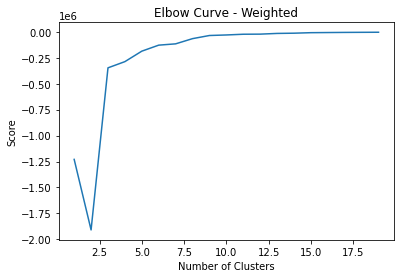

In [8]:
clust_start = time.time()

K_clusters = range(1,20)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]

lat_long = X_weighted[X_weighted.columns[1:3]]
lot_size = X_weighted[X_weighted.columns[3]]

sample_weight = lot_size

score = [kmeans[i].fit(lat_long, sample_weight = lot_size).score(lat_long) for i in range(len(kmeans))]

plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')

plt.ylabel('Score')
plt.title('Elbow Curve - Weighted')

plt.show()

clust_end = time.time()

<Figure size 1440x1440 with 0 Axes>

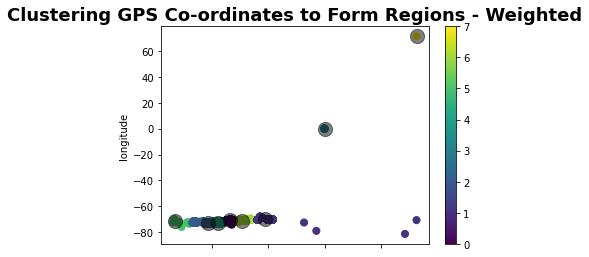

In [9]:
kmean_start = time.time()

kmeans = KMeans(n_clusters = 8, max_iter=1000, init ='k-means++')

lat_long = X_weighted[X_weighted.columns[1:3]]
lot_size = X_weighted[X_weighted.columns[3]]
weighted_kmeans_clusters = kmeans.fit(lat_long, sample_weight = lot_size) # Compute k-means clustering.
X_weighted['cluster_label'] = kmeans.predict(lat_long, sample_weight = lot_size)

centers = kmeans.cluster_centers_ # Coordinates of cluster centers.

labels = X_weighted['cluster_label'] # Labels of each point

plt.figure(figsize=(20,20))

X_weighted.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title('Clustering GPS Co-ordinates to Form Regions - Weighted',fontsize=18, fontweight='bold')

plt.show()

kmean_end = time.time()

In [10]:
df_final = pd.merge(X_weighted, df[['name','street']], on='name', how='inner')

In [11]:
df_final['name'] = df_final['name'].str.lower()
df_final[df_final['name'].str.contains('parque arauco', na=False)]

,name,latitude,longitude,distance,cluster_label,street
1566,streat ice cream - parque arauco,-33.401344,-70.578325,46.799972,0,Av. Presidente Kennedy 5413
2923,emporio la rosa - parque arauco,-33.402500,-70.577103,46.884597,0,"Av Presidente Kennedy 5413, local 561 -"
2997,mokka parque arauco - café,-33.402500,-70.578903,46.720696,0,Avenida Presidente Kennedy 5413 -
3727,tommy beans - mall parque arauco,-33.402100,-70.579697,46.657682,0,Av. Presidente Kennedy 5413 -
4465,up burger - parque arauco,-33.401798,-70.577400,46.873599,0,"Avda. Kennedy N°5413, Local 385 -"
4549,helados palettas parque arauco,-33.402699,-70.577599,46.834926,0,"Av Presidente Kennedy 5413, local 7256 -"
6518,dominó - parque arauco,-33.402199,-70.579597,46.664424,0,Avenida Presidente Kennedy 5413 -
8663,dony doner - parque arauco,-33.402140,-70.577142,46.889230,0,Avenida Presidente Kennedy 5413 -
8664,dony doner - parque arauco,-33.402140,-70.577142,46.889230,0,Av Presidente Kennedy 5413
8665,dony doner - parque arauco,-33.402217,-70.577132,46.888421,0,Avenida Presidente Kennedy 5413 -


In [12]:
print('Tiempo distancia:',dist_end-dist_start)
print('Tiempo clusters inicio:',clust_end-clust_start)
print('Tiempo kmeans inicio:',kmean_end-kmean_start)

Tiempo distancia: 18.94689393043518
Tiempo clusters inicio: 7.399819850921631
Tiempo kmeans inicio: 1.2961201667785645


                          geometry
0      POINT (-70.70618 -33.59628)
1      POINT (-71.43185 -32.64395)
2      POINT (-70.40381 -23.66151)
3      POINT (-70.49868 -33.36595)
4      POINT (-70.64829 -33.43586)
...                            ...
57315  POINT (-70.59950 -33.44090)
57316  POINT (-70.60960 -33.46150)
57317  POINT (-73.04170 -36.82150)
57318  POINT (-72.56740 -38.73550)
57319  POINT (-70.59396 -33.45254)

[57320 rows x 1 columns]


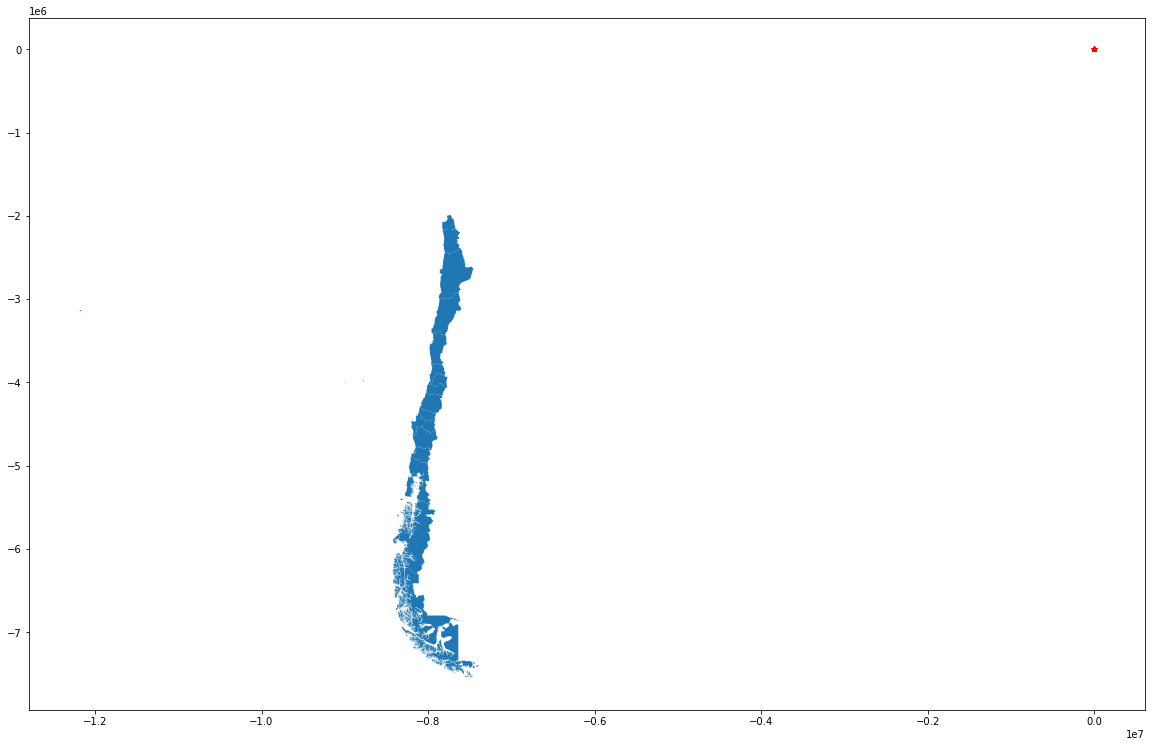

In [13]:
lo = df.longitude.tolist()
la = df.latitude.tolist()

mapa_chile = gpd.read_file(r'Regional.shp')

fig,ax = plt.subplots(figsize = (20,20))

mapa_chile.plot(ax = ax)

geometry = [Point(xy) for xy in zip(lo,la)]
geo_df = gpd.GeoDataFrame(geometry = geometry)

print(geo_df)
g = geo_df.plot(ax = ax, markersize = 20, color = 'red',marker = '*',label = 'Delhi')

plt.show()

In [20]:
# Variable with the Longitude and Latitude
X=df.loc[:,['name','latitude','longitude']]
X.head(10)

,name,latitude,longitude
0,El Pollo Kimey,-33.596276,-70.706176
1,empanaderia,-32.643949,-71.431852
2,Chiken Mouse,-23.661511,-70.403806
3,Macarena Errazuriz productos Gourmet,-33.365946,-70.498679
4,Restaurant victoria,-33.435865,-70.648288
5,Sushi,-36.627090,-72.106040
6,serv eventos Sergio,-31.910657,-71.509280
7,beweis,-31.907307,-71.498937
8,Restaurant,-38.452049,-71.370768
9,Bambu sushi,-36.602716,-72.090666


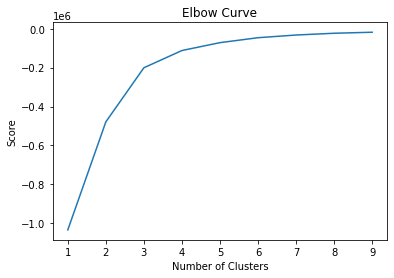

In [18]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = df[['latitude']]
X_axis = df[['longitude']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize

plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [21]:
kmeans = KMeans(n_clusters = 4, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
X.head(10)

,name,latitude,longitude,cluster_label
0,El Pollo Kimey,-33.596276,-70.706176,0
1,empanaderia,-32.643949,-71.431852,0
2,Chiken Mouse,-23.661511,-70.403806,1
3,Macarena Errazuriz productos Gourmet,-33.365946,-70.498679,0
4,Restaurant victoria,-33.435865,-70.648288,0
5,Sushi,-36.627090,-72.106040,2
6,serv eventos Sergio,-31.910657,-71.509280,0
7,beweis,-31.907307,-71.498937,0
8,Restaurant,-38.452049,-71.370768,2
9,Bambu sushi,-36.602716,-72.090666,2


In [22]:
X.cluster_label.value_counts()

0    43967
2     8854
1     3954
3      545
Name: cluster_label, dtype: int64

In [23]:
def haversine_distance(lon1, lat1, lon2, lat2,**kwargs):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    All args must be of equal length.
    
    Sourced from https://stackoverflow.com/a/29546836/11637704
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [24]:
from sklearn.cluster import DBSCAN

def dbscan_cluster(latitudes,longitudes,epsilon,min_samples,**kwargs):
    '''
    Function to perform DBSCAN clustering for given parameters.
    
    '''
    
    # convert epsilon from km to radians
    kms_per_radian = 6371.0088
    epsilon /= kms_per_radian
    
    # set up the algorithm
    dbscan = DBSCAN(
        eps = epsilon,
        min_samples = min_samples,
        algorithm = 'ball_tree',
        metric = 'haversine',
        **kwargs
    )
    
    # fit the algorithm
    dbscan.fit(
        np.radians(
            [x for x in zip(latitudes,longitudes)]
        )
    )
    
    # return the cluster labels
    return pd.Series(dbscan.labels_)

In [25]:
def vertex_centroid_distance(latitudes,longitudes,**kwargs):
    '''
    Function to calculate the average distance from the vertices of a convex hull
    (derived from latitude x longitude pairs) to the centroid of said convex hull.
    
    Centroid is taken to be the unweighted average of all co-ordinate pairs.
    
    '''
    
    # co-ordinates of centre
    # take a simple average
    centre_long = longitudes.mean()
    centre_lats = latitudes.mean()
    
    # collapse two points into line
    if len(latitudes) < 3:
        distances = haversine_distance(
            longitudes,
            latitudes,
            centre_long,
            centre_lats,
            **kwargs).mean()
    
    else:
        # convex hull
        convex_hull = ConvexHull([x for x in zip(latitudes,longitudes)],**kwargs)

        # now get co-ordinates of vertices
        vertex_longs = longitudes.iloc[convex_hull.vertices]
        vertex_lats = latitudes.iloc[convex_hull.vertices]

        # now get
        distances = haversine_distance(
            vertex_longs,
            vertex_lats,
            centre_long,
            centre_lats,
            **kwargs).mean()

    # return average distance
    return distances.mean()

In [66]:
def haversine(lon1, lat1, lon2, lat2):
    
    
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)

    r = 6371
    
    
    dlon = np.subtract(lon2, lon1)
    dlat = np.subtract(lat2, lat1)

    a = np.add(np.power(np.sin(np.divide(dlat, 2)), 2),
               np.multiply(np.cos(lat1),
                           np.multiply(np.cos(lat2),
                                       np.power(np.sin(np.divide(dlon, 2)), 2))
                           )
              )
    c = np.multiply(2, np.arcsin(np.sqrt(a)))

    return c*r

In [70]:
start = time.time()
# Variable with the Longitude and Latitude
df_test = df.loc[0:100,['name','latitude','longitude']]
df_result = pd.DataFrame([])

for name in df.name.tolist():
    print(name)
    #Tomamos todos los valores menos el codigo a buscar
    aux = df_test
    row = pd.DataFrame(data={'name':'media', 'latitude':df.latitude.mean(), 'longitude':df.longitude.mean()}, index=range(0,1))
    #Asignamos una columna con el valor del código para tener en la misma fila el código consultado.
    aux['name_consultado'] = name
    
    #definimos la columna distancia en la que vamos a asignar el resultado de haber aplicado la función al df.
    aux['distancia'] = aux.apply(lambda fila: haversine(row.longitude.iloc[0],
                                                    row.latitude.iloc[0],
                                                    fila['longitude'],
                                                    fila['latitude']),
                             axis=1)
    #Agregamos el dataframe reducido a nuestro dataframe resultante.
    df_result = df_result.append(aux)

end = time.time()
print(end - start)

SyntaxError: 'return' outside function (Temp/ipykernel_9984/1675969132.py, line 22)

In [68]:
final = int(end-start)/60
print(final)

49.68333333333333


In [73]:
df_geo = df[['name','latitude','longitude']]
df_geo = gpd.GeoDataFrame(df_geo.name, geometry=gpd.points_from_xy(df_geo.longitude,df_geo.latitude, crs='epsg:4326'))

In [77]:
def buffer_in_mercator(geometry, distance_x_meters):
    crs = geometry.crs
    return
    geometry.to_crs(epsg=3395).buffer(distance_x_meters).to_crs(crs)

In [82]:
df = pd.read_parquet('datos_geo_cluster.parquet')

In [86]:
X=df.loc[:100,['name','latitude','longitude']]

In [88]:
K_clusters = range(1,10)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = X[['latitude']]
X_axis = X[['longitude']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

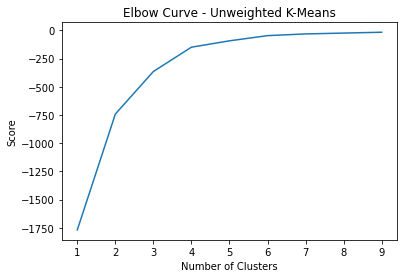

In [89]:
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')

plt.ylabel('Score')

plt.title('Elbow Curve - Unweighted K-Means')

plt.show()

Text(0.5, 1.0, 'Clustering GPS Co-ordinates to Form Regions - Unweighted')

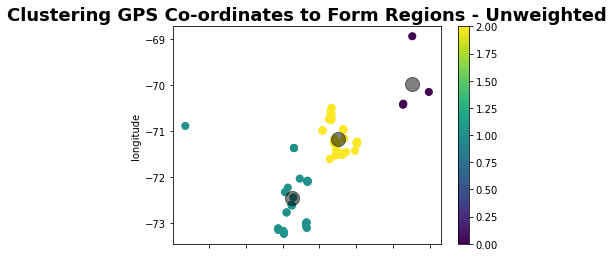

In [90]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.

X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])

centers = kmeans.cluster_centers_ # Coordinates of cluster centers.

labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point

#Visualise Resutls
X.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title('Clustering GPS Co-ordinates to Form Regions - Unweighted',fontsize=18, fontweight='bold')